# Configuración Inicial

In [1]:
import sys
import os
import numpy as np

def setup_workdirectory(
    repo_url="https://github.com/kikaymusic/EscuderoRodriguezSanchez.git",
    branch="dev",
    repo_name="EscuderoRodriguezSanchez",
    directoy_name="Entornos_Complejos"
):
    """
    Función para detectar si el código se está ejecutando en Google Colab o en local
    y configurar el entorno de trabajo en consecuencia.
    """
    # Detectamos si estamos en Google Colab
    in_colab = "google.colab" in sys.modules

    if in_colab:
        print("Entorno detectado: Google Colab")

        # Definimos la ruta del repositorio en Colab
        repo_path = f"/content/{repo_name}"

        # Borramos el repositorio si ya existe para evitar conflictos
        if os.path.exists(repo_path):
            os.system(f"rm -rf {repo_path}")

        # Clonamos la rama especificada del repositorio
        os.system(f"git clone -b {branch} --single-branch {repo_url}")

        # Cambiamos al directorio del repositorio
        os.system(f"%cd {repo_path}")

        # Añadimos el directorio especificado al path
        sys.path.append(f'/content/{repo_name}/{directoy_name}')

    else:
        print("Entorno detectado: Local")

        # Añadir el directorio especificado al path de Python
        notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in globals() else os.getcwd()
        k_brazos_dir = notebook_dir if directoy_name in notebook_dir else os.path.join(notebook_dir, directoy_name)
        if k_brazos_dir not in sys.path:
            sys.path.insert(0, k_brazos_dir)


setup_workdirectory()

Entorno detectado: Local


# Imports

In [2]:
import gymnasium as gym
from src.train import train_agent
from src.agents.sarsa import AgentSarsa
from src.agents.qlearning import AgentQLearning
from src.utils import SEMILLA
from src.policies.epsilon_greedy import EpsilonGreedyPolicy
from src.policies.epsilon_soft import EpsilonSoftPolicy
from src.utils import q_to_v_and_policy
from src.UI import evaluate_agent_visual
import matplotlib.pyplot as plt
from src.plots import (
    plot_blackjack_values,
    plot_policy,
    plot_q_heatmap,
    plot_rewards,
    capture_figure,
    compare_plots
)

# Blackjack con Agente SARSA

Vamos a empezar ejecutando el entorno con el agente SARSA. Como es un algoritmo On-Policy, la política de comportamiento y la objetivo serán la misma, por lo que solo será necesario escoger una. En nuestro caso, vamos a elegir $\epsilon$-soft, ya que SARSA es un algoritmo que tiende a encontrar soluciones menos óptimas pero más seguras, y la exploración extra que nos proporciona $\epsilon$-soft nos beneficia siguiendo esta filosofía. Además, necesitamos una política que tenga mayor exploración para de que el algoritmo converja.

In [3]:
env = gym.make("Blackjack-v1", render_mode="rgb_array", sab=True)

# Inicializamos la política con la semilla
esoft_policy = EpsilonSoftPolicy(epsilon=0.1, n_actions=env.action_space.n, seed=SEMILLA)

# Inicializamos el agente SARSA con el entorno y la política
sarsa_agent = AgentSarsa(env, esoft_policy)

# Al iniciar el entrenamiento, le pasamos la semilla al entorno
state, info = env.reset(seed=SEMILLA)

In [4]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


## Visualización de juego pre-entrenamiento

In [5]:
results_before_on = evaluate_agent_visual(
    env, sarsa_agent,
    n_episodes=10,
    seed_base=SEMILLA,
    delay=0.2,
    greedy_eval=True
)
print(results_before_on)

{'wins': 1, 'losses': 8, 'draws': 1, 'win_rate': 10.0, 'episodes': 10}


## Entrenamiento del Agente

In [6]:
episode_returns_sarsa, episode_lengths_sarsa = train_agent(env, sarsa_agent)

Episode 5000/80000 - avg_return_last_5000=-0.1548
Episode 10000/80000 - avg_return_last_5000=-0.1090
Episode 15000/80000 - avg_return_last_5000=-0.1180
Episode 20000/80000 - avg_return_last_5000=-0.1330
Episode 25000/80000 - avg_return_last_5000=-0.1032
Episode 30000/80000 - avg_return_last_5000=-0.0864
Episode 35000/80000 - avg_return_last_5000=-0.0866
Episode 40000/80000 - avg_return_last_5000=-0.1048
Episode 45000/80000 - avg_return_last_5000=-0.1096
Episode 50000/80000 - avg_return_last_5000=-0.1032
Episode 55000/80000 - avg_return_last_5000=-0.1016
Episode 60000/80000 - avg_return_last_5000=-0.0916
Episode 65000/80000 - avg_return_last_5000=-0.0994
Episode 70000/80000 - avg_return_last_5000=-0.1018
Episode 75000/80000 - avg_return_last_5000=-0.1068
Episode 80000/80000 - avg_return_last_5000=-0.1052


## Calculo de superficie de Valores de Estado

In [7]:
V_sarsa, policy_sarsa = q_to_v_and_policy(sarsa_agent.q_table)

# Blackjack con Agente Q-Learning

Ahora vamos a ejecutar el entorno con el agente Q-Learning. En este caso, como el algoritmo es Off-Policy, necesitaremos una política de comportamiento y otra objetivo. Para la política de comportamiento, hemos elegido $\epsilon$-soft, ya que la política de comportamiento es la encargada de generar datos y necesitamos una política que explore más para descubrir si hay mejores recompensas. Para la política objetivo, hemos elegido $\epsilon$-greedy, ya que necesitamos una política que explote las mejores acciones encontradas.

In [8]:
# Inicializamos las política con la semilla
behavior_policy_qlearning = EpsilonSoftPolicy(epsilon=0.1, n_actions=env.action_space.n, seed=SEMILLA)
target_policy_qlearning = EpsilonGreedyPolicy(epsilon=0.1, n_actions=env.action_space.n, seed=SEMILLA)

# Inicializamos el agente Q-Learning con el entorno y las políticas
qlearning_agent = AgentQLearning(env, behavior_policy_qlearning, target_policy_qlearning)

# Al iniciar el entrenamiento, le pasamos la semilla al entorno
state, info = env.reset(seed=SEMILLA)

In [9]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


## Visualización de juego pre-entrenamiento

In [10]:
results_before_on = evaluate_agent_visual(
    env, qlearning_agent,
    n_episodes=10,
    seed_base=SEMILLA,
    delay=0.2,
    greedy_eval=True
)
print(results_before_on)

{'wins': 1, 'losses': 8, 'draws': 1, 'win_rate': 10.0, 'episodes': 10}


## Entrenamiento del Agente

In [11]:
episode_returns_qlearning, episode_lengths_qlearning = train_agent(env, qlearning_agent)

Episode 5000/80000 - avg_return_last_5000=-0.1556
Episode 10000/80000 - avg_return_last_5000=-0.1228
Episode 15000/80000 - avg_return_last_5000=-0.1290
Episode 20000/80000 - avg_return_last_5000=-0.1098
Episode 25000/80000 - avg_return_last_5000=-0.0946
Episode 30000/80000 - avg_return_last_5000=-0.1092
Episode 35000/80000 - avg_return_last_5000=-0.0968
Episode 40000/80000 - avg_return_last_5000=-0.1040
Episode 45000/80000 - avg_return_last_5000=-0.0924
Episode 50000/80000 - avg_return_last_5000=-0.1108
Episode 55000/80000 - avg_return_last_5000=-0.1020
Episode 60000/80000 - avg_return_last_5000=-0.0870
Episode 65000/80000 - avg_return_last_5000=-0.1030
Episode 70000/80000 - avg_return_last_5000=-0.1072
Episode 75000/80000 - avg_return_last_5000=-0.1052
Episode 80000/80000 - avg_return_last_5000=-0.0878


## Calculo de superficie de Valores de Estado

In [12]:
V_qlearning, policy_qlearning = q_to_v_and_policy(qlearning_agent.q_table)

# Comparativa entre agentes

### Tendencia de recompensas

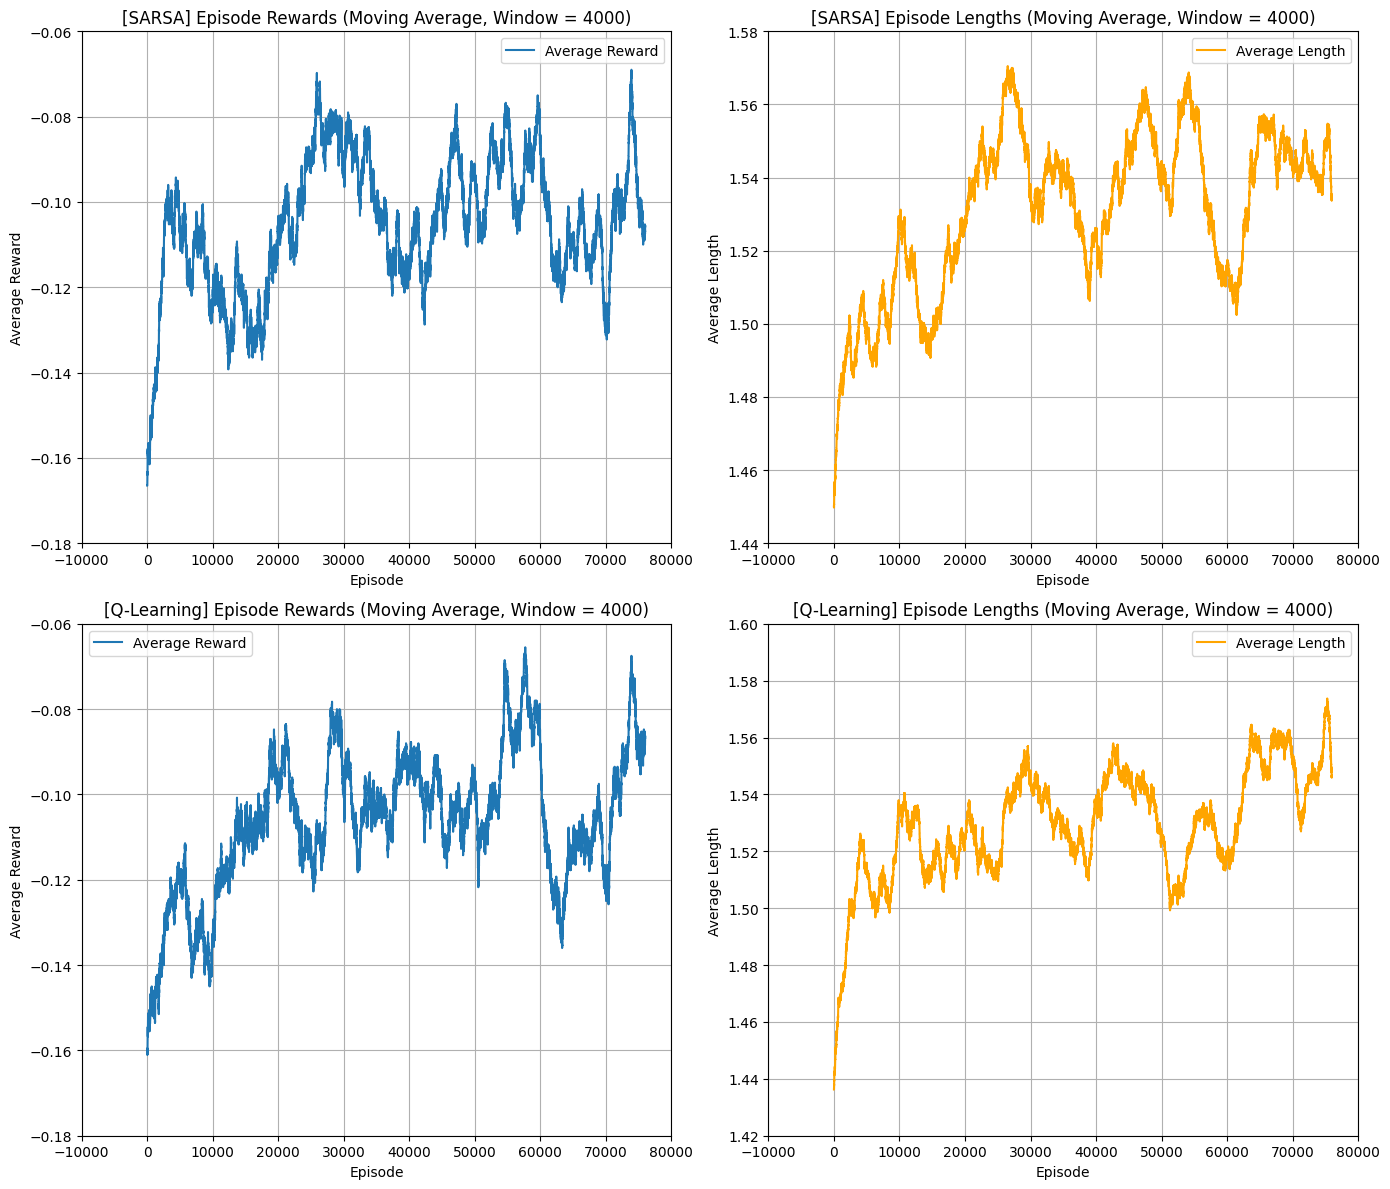

In [13]:
compare_plots(
    plot_rewards,
    agents_data=[(episode_returns_sarsa, episode_lengths_sarsa), (episode_returns_qlearning, episode_lengths_qlearning)],
    agent_names=["SARSA", "Q-Learning"],
    window=4000
)

**SARSA**: Recompensa media y duración media

---

- Al principio, la recompensa media parte muy negativa (~‑0.19). Esto se debe a que el agente aún no ha aprendido qué decisiones resultan en mejores retornos en Blackjack. Con pocas experiencias, las actualizaciones de valor están basadas en trayectorias poco representativas. 
- En los **primeros ~5000 episodios** se aprecia una subida sostenida. Esto refleja que, conforme el agente acumula experiencias siguiendo *su propia política*, aprende qué acciones y secuencias evitan resultados negativos o conducen a tablas/ganancias. A partir de aquí, podemos ver que los valores oscilan entre -0.13 y -0.7, pero centrandose sobre todo entre -0.12 y -0.8. En general, consideramos que los valores se mantienen más o menos estables.
- Los **picos** en la gráfica representan momentos en los que, por azar y exploración limitada, se generan episodios con retornos menos negativos o empates/ganancias más frecuentes. Estos picos indican momentos de exploración donde el agente encuentra trayectorias de alto retorno debido a una exploración oportuna dentro de su política.
- La **duración media de episodios tiende a aumentar** con el tiempo. Esto indica que, a medida que la política mejora, el agente evita terminar rápidamente (por bustear o plantarse de forma prematura) y toma decisiones más equilibradas entre pedir y plantarse, extendiendo el número de pasos hasta llegar al resultado final. Esto también refleja que el agente está aprendiendo a manejar mejor la incertidumbre y las decisiones difíciles, lo que resulta en episodios más largos.


**Q-Learning**: Recompensa media y duración media 

---

- Al principio, la recompensa media parte en ~‑0.16, y podemos apreciar una gran subida en los **primeros ~5000 episodios** gracías a la experiencia acumulada siguiendo *su propia política*. Aún así, podemos ver justo después una bajada bastante pronuncia, que deja las recompensas cerca de como estabamos al principio. Después podemos apreciar un comportamiento muy similar al visto en el algoritmo **SARSA**.
- Igual que en el algoritmo anterior, podemos apreciar **picos** en la gráfica debidos al azar, y que la **duración media de episodios tiende a aumentar** a medida que la política mejora.

---

En ambos algoritmos podemos apreciar un comportamiento similar, teniendo una gran subida al principio debido al aprendizaje inicial, y después una oscilación entre varios valores. Si comparamos los valores, podemos ver que **SARSA** tiene en general unos valores un poco más estables que **Q-Learning**. También podemos apreciar que de media los episodios de **Q-Learning** son un poco más largos que los de **SARSA**. Como vimos en el problema del acantilado, **Q-Learning** encontraba caminos más óptimos pero con más riesgo que **SARSA**, lo que hacía que al final **SARSA** generase mejores recompensas de media debido al riesto de caerse. Este comportamiento se puede apreciar también aquí, ya que podemos ver como **Q-Learning** tiene episodios más largos, probablemente por que el algoritmo tienda a pedir más cartas buscando una mejor puntuación, pero a la vez teniendo partidas con mayor riesgo y haciendo que también pierda más veces, cosa que podemos ver en la mayor oscilación en las recompensas promedio en comparación a **SARSA**

### Mapa de Política Aprendida

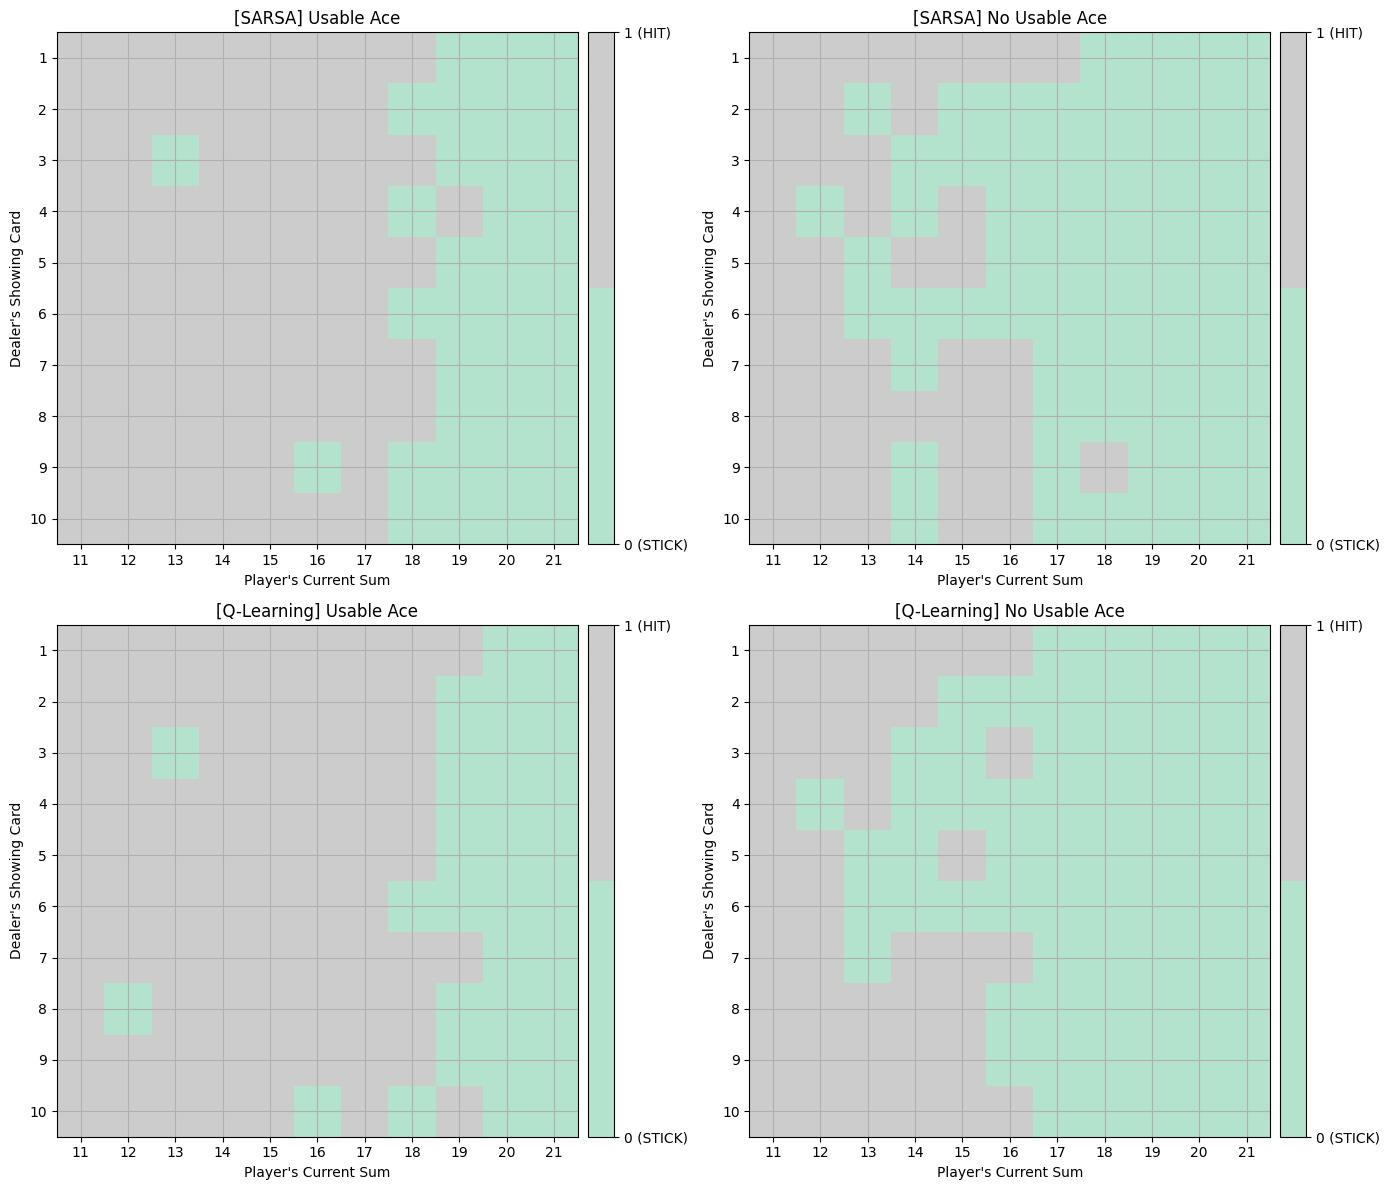

In [14]:
compare_plots(
    plot_policy,
    agents_data=[(policy_sarsa), (policy_qlearning)],
    agent_names=["SARSA", "Q-Learning"]
)

**Ejes de la gráfica**

---

- **Eje horizontal (Player's Current Sum)**: Representa la suma de las cartas actuales del jugador, que varía entre 11 y 21. Este valor es crucial porque el jugador debe decidir si pide otra carta o se planta en función de este total. La suma es un indicador de la seguridad de la mano del jugador: valores bajos (11-16) requieren decisiones más cautelosas, mientras que valores más altos (17-21) permiten decisiones más conservadoras.
- **Eje vertical (Dealer’s Showing Card)**: Muestra la carta visible del crupier, que puede estar entre 1 y 10 (el As cuenta como 1 o 11, pero aquí se cuenta como 1). El crupier influye en las decisiones del jugador, ya que este debe anticipar la probabilidad de que el crupier termine con un total superior o inferior al 21.

SARSA

---

- As utilizable:
    - Cuando el entorno tiene carta de As como utilizable (es decir, un As que puede contar como 11 sin riesgo de exceder 21), las decisiones del agente siguen un patrón lógico: **"Hit"** (pedir carta) cuando la suma del jugador es baja (alrededor de 11-17), y **"Stick"** (plantarse) cuando la suma alcanza valores más altos (18-21). La presencia del As permite al jugador un **margen de maniobra**, ya que el riesgo de exceder 21 es reducido, lo que justifica la decisión de arriesgarse a pedir cartas adicionales.
- As no utilizable:
    - Cuando el entorno no incluye el As como utilizable, el agente sigue una estrategia similar, pero con **menos flexibilidad**, ya que el As no puede ser contado como 11. El agente opta por **"Hit"** cuando la suma es baja (11-14) y **"Stick"** más rápido, a partir de 15, en comparación con el caso anterior donde el "As utilizable" da más margen. Esta menor flexibilidad refleja la necesidad de ser más conservador en las decisiones cuando las cartas disponibles no ofrecen tanto margen de maniobra. En situaciones de "As no utilizable", el riesgo de sobrepasar 21 es mayor, lo que hace que el agente sea más conservador al momento de decidir si pedir o no otra carta.

Q-Learning

---

- As utilizable:
    - En el caso de **Q-Learning**, podemos observar como el algoritmo toma más riesgos y empieza a hacer **"Stick"** de forma más consistente a partir de valor 19, en vez de 18 como en el caso de **SARSA**.
- As no utilizable:
    - Cuando el entorno no incluye el As como utilizable, el agente toma una estrategia más conservadora, muy similar a la que tomaba el agente anterior. El agente opta por **"Hit"** cuando la suma es baja (11-14) y **"Stick"** más rápido, a partir de 15, en comparación con el caso anterior donde el "As utilizable" da más margen.

Conclusiones

- **SARSA** sigue estrategias más definidas y conservadoras, que se ajustan estrictamente a la política aprendida hasta el momento. En situaciones donde el jugador tiene un "As utilizable", la decisión de pedir carta se ve claramente más extendida, mientras que con un "As no utilizable", el agente tiende a plantarse antes.
- **Q-Learning** sigue una estrategia muy similar a **SARSA** en el caso de no tener un "As utilizable", pero cuando si lo tiene sigue una estrategia un poco más arriesgada pidiendo más cartas para buscar puntuaciones más altas.

### Superficie de Valores de Estado

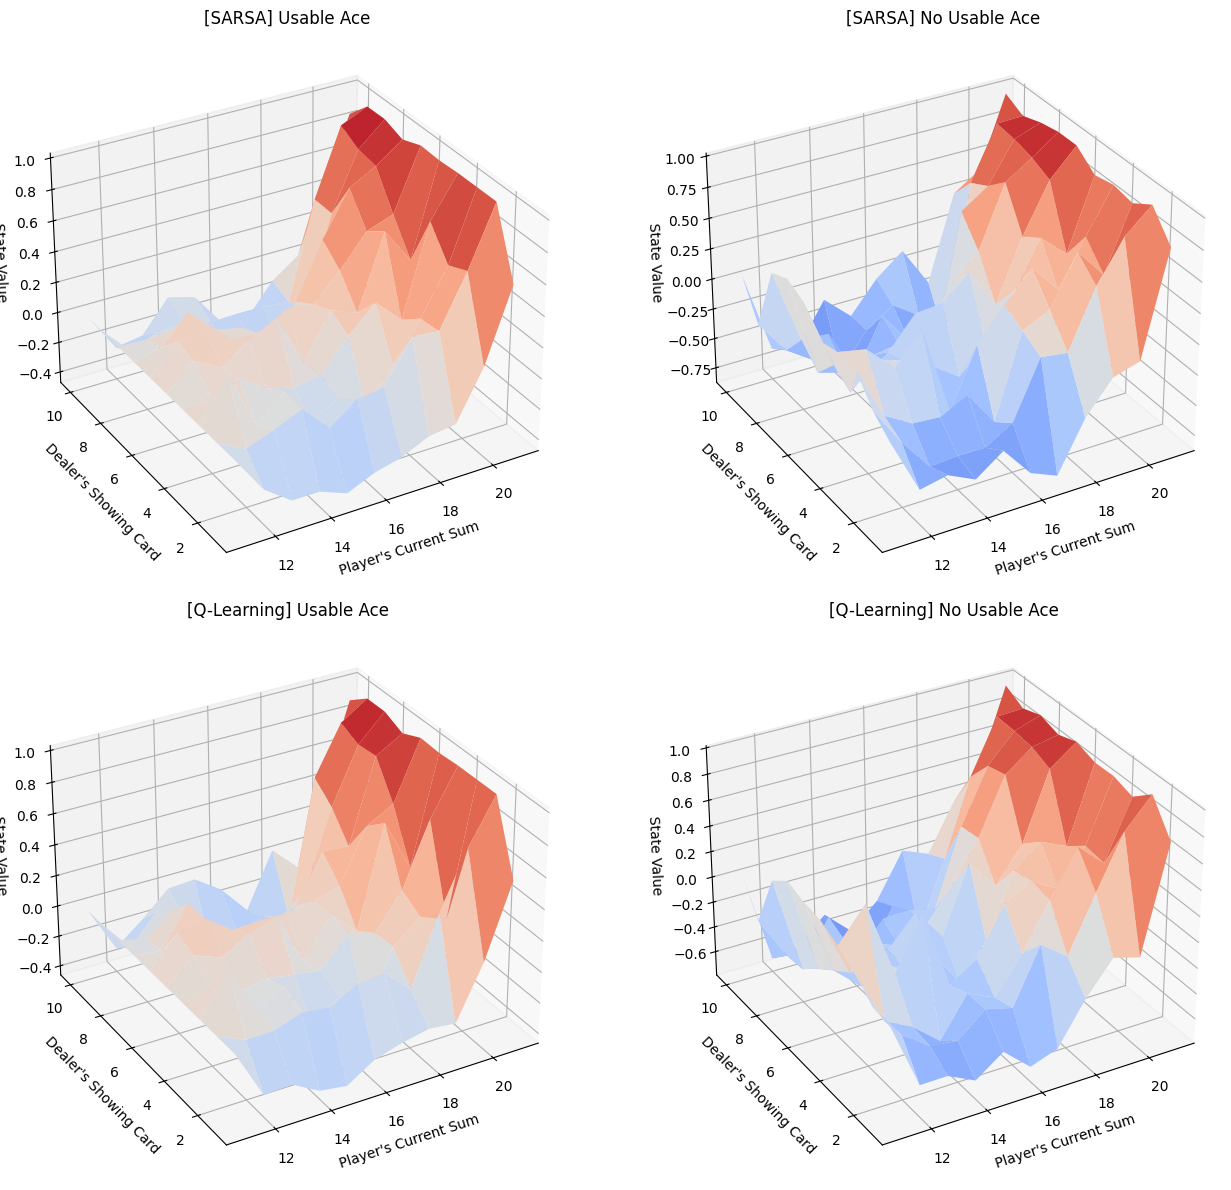

In [15]:
compare_plots(
    plot_blackjack_values,
    agents_data=[(V_sarsa), (V_qlearning)],
    agent_names=["SARSA", "Q-Learning"]
)

**Ejes de la gráfica**

---

- **Eje horizontal (Player's Current Sum)**: Representa la suma de las cartas del jugador, que varía entre 11 y 21. Este valor es crucial ya que determina las decisiones de "Hit" (pedir carta) o "Stick" (plantarse).
- **Eje vertical (Dealer’s Showing Card)**: Representa la carta visible del crupier, que puede ser cualquier valor entre 1 y 10, con el As contando como 1 en este caso.
- **Eje Z (State Value)**: Este eje muestra el **valor estimado de estado**: el valor de estar en una combinación específica de la suma del jugador y la carta visible del crupier. Los valores más altos (rojo) indican que el estado es **más favorable**, lo que significa que el agente debería tomar la acción que maximiza las recompensas a largo plazo (por ejemplo, pidiendo más cartas o plantándose). Los valores más bajos (azul) indican que el estado es **menos favorable** y el agente debería ser más conservador, evitando tomar decisiones riesgosas.


SARSA

---
- As utilizable:
    - **Valor positivo en estados cercanos a 21**: Como se muestra en la gráfica, cuando el jugador tiene un **As utilizable**, la función de valor es alta (rojo) en situaciones donde la suma del jugador está entre **19-21**, lo que indica que es **beneficioso** pedir más cartas en situaciones en las que el jugador tiene un **As utilizable**. Esto ocurre porque un **As utilizable** reduce el riesgo de *exceder 21*, lo que le permite al jugador explorar más posibles combinaciones.
    - **Valor negativo en estados de baja suma**: En estados donde la suma del jugador es baja (por ejemplo, 11-14), el valor del estado disminuye (zonas azules), lo que sugiere que el agente debería estar más dispuesto a **pedir carta** para aumentar la probabilidad de alcanzar un total cercano a 21 sin excederlo.
- As no utilizable:
    - **Valor negativo en zonas de baja suma**: Cuando el jugador no tiene un **As utilizable**, las decisiones del agente son más conservadoras. Se observa que en la **suma baja** (11-14), el valor de la función de valor es más negativo, ya que el riesgo de exceder 21 es más alto. En estos casos, el agente opta por **plantarse** más rápidamente debido al mayor riesgo de perder.
    - **Aumento de valor a partir de la suma 18**: El valor del estado se incrementa a medida que la suma del jugador se aproxima a 18 o más, ya que es una suma de por sí alta sin necesidad de arriesgarse a pedir más cartas.

Q-Learning

---

- As utilizable:
    - **Valor positivo en estados cercanos a 21**: Como se muestra en la gráfica, cuando el jugador tiene un **As utilizable**, la función de valor es alta (rojo) en situaciones donde la suma del jugador está entre **19-21**, lo que indica que es **beneficioso** pedir más cartas en situaciones en las que el jugador tiene un **As utilizable**.
    - **Valor negativo en estados de baja suma**: En estados donde la suma del jugador es baja (por ejemplo, 11-14), el valor del estado disminuye (zonas azules), lo que sugiere que el agente debería estar más dispuesto a **pedir carta** para aumentar la probabilidad de alcanzar un total cercano a 21 sin excederlo.
- As no utilizable:
    - **Valor negativo en zonas de baja suma**: Cuando el jugador no tiene un **As utilizable**, las decisiones del agente son más conservadoras y opta por **plantarse** más rápidamente debido al mayor riesgo de perder. Aún así, podemos ver resultados ligeramente superiores a los de **SARSA**, debido a que este agente tiende más a pedir más cartas.
    - **Aumento de valor a partir de la suma 18**: El valor del estado se incrementa a medida que la suma del jugador se aproxima a 18 o más, ya que es una suma de por sí alta sin necesidad de arriesgarse a pedir más cartas.

### Distribución de Q-Valores por Acción dado un Estado

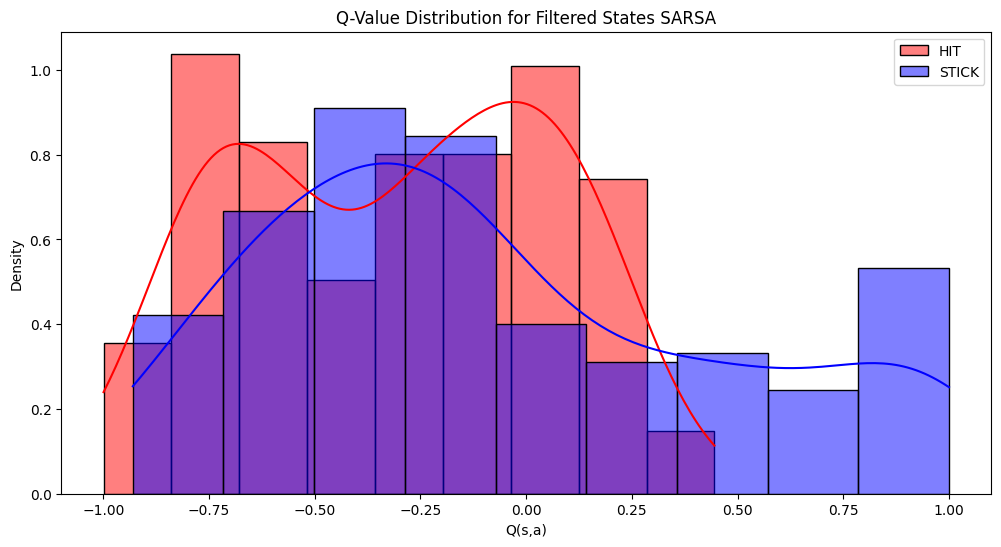

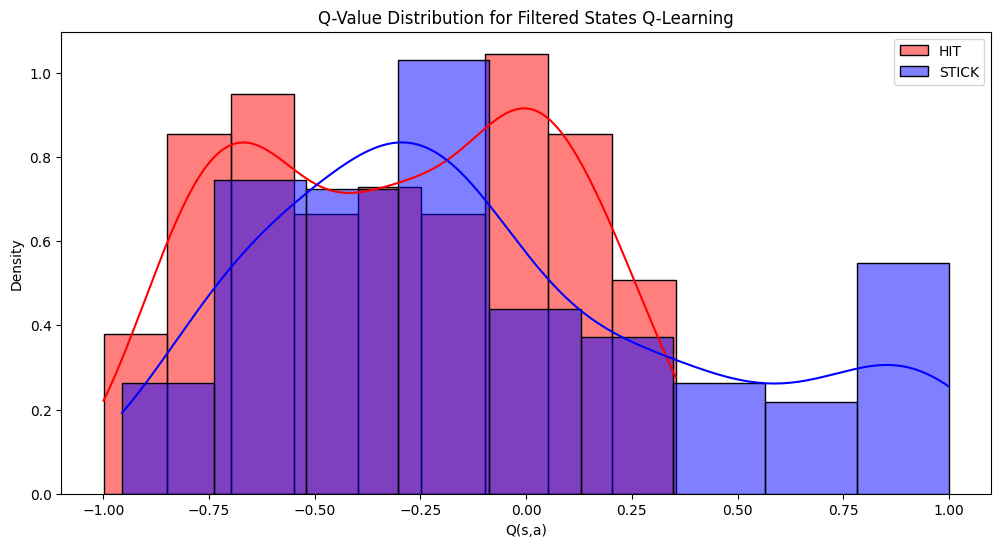

In [16]:
plot_q_heatmap(
    sarsa_agent.q_table,
    state_filter_fn=lambda s: (isinstance(s, tuple) and len(s) == 3 and 11 <= s[0] <= 21),
    label="SARSA"
)

plot_q_heatmap(
    qlearning_agent.q_table,
    state_filter_fn=lambda s: (isinstance(s, tuple) and len(s) == 3 and 11 <= s[0] <= 21),
    label="Q-Learning"
)

Distribución de valores Q por acción: Comparativa SARSA vs Q-Learning

---

Esta visualización corresponde a un gráfico de densidad (con curvas de densidad Kernel Density Estimation) superpuesto a un histograma, que muestra la distribución de valores $Q(s,a)$ para las dos acciones (`HIT` y `STICK`) en un subconjunto de estados filtrados considerando únicamente aquellos con la suma del jugador entre 11 y 21.

**Interpretación de la gráfica:**
Para comprender correctamente la política que el agente está formando, es fundamental desglosar la visualización:

* **Eje X ($Q(s,a)$):** Representa el valor esperado o "esperanza matemática de victoria". Está acotado entre -1 y 1. Valores cercanos a -1 indican acciones casi siempre perdedoras, el 0 representa incertidumbre o empates frecuentes, y los valores cercanos a 1 indican una alta probabilidad de ganar.
* **Eje Y (Densidad):** Refleja la concentración o frecuencia de estados que comparten ese mismo valor estimado.
* **Curva Roja (`HIT`):** Se observa fuertemente desplazada hacia la zona negativa. Esto es coherente con las reglas del Blackjack: pedir carta cuando la suma ya es alta (11-21) resulta frecuentemente en pasarse (*bust*), por lo que el agente aprende a penalizar esta acción.
* **Curva Azul (`STICK`):** Muestra una mayor dispersión. Destacan los picos en el extremo positivo derecho (ej. plantarse con 20 o 21 garantiza casi siempre ganar). Sin embargo, también tiene presencia en la zona negativa, lo que refleja que plantarse con sumas débiles frente a cartas fuertes del crupier también es una acción perdedora a largo plazo.
* **Zonas de Solapamiento:** La superposición de ambas curvas (especialmente en la zona negativa) representa estados "críticos" o desfavorables por naturaleza (ej. jugador suma 15 y crupier muestra un 10). En estos casos, la ventaja estructural la tiene el crupier, por lo que ambas opciones arrojan un valor esperado negativo y convergen en estimaciones muy similares.

El solapamiento entre distribuciones es esperable en Blackjack, ya que en muchos estados las dos acciones pueden tener valores relativamente próximos. Esta gráfica resulta útil para analizar la estabilidad de la estimación de `Q` y para entender en qué medida una acción está siendo preferida sobre la otra en distintos rangos de estados.

---

**Análisis Comparativo:**
Al contrastar las distribuciones obtenidas para SARSA y Q-Learning, las diferencias que hemos encontrado son las siguientes:
* **SARSA:** La curva roja (`HIT`) tiene picos más pronunciados en valores bajos, principalmente en -0.75, por lo que SARSA penaliza con más fuerza las decisiones de `HIT` que resultan en perder una partida. En la curva azul (`STICK`) podemos observar una curva más suave, debido probablemente a ser un algoritmo On-Policy y no haber conflictos entre la política de comportamiento y objetivo.

* **Q-Learning:** Podemos ver la curva azul (`STICK`) un poco más desplazada a la derecha, por lo que tiende a ser un algoritmo más optimista que piensa que va a tomar la decisión correcta. También se puede apreciar que tanto la curva azul (`STICK`) como la roja (`HIT`) tienen bastantes valores en el centro, ya que el algoritmo intenta ser optimista y empujar la gráfica hacía la derecha generando recompensas altas, pero probablemente sean estados en los que el algoritmo pierda y las recompensas se queden en valores más intermedios.